In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۴ — مبانی یادگیری نظارت‌شده
## درس ۱: مقدمه‌ای بر رگرسیون و دسته‌بندی

در این درس، یک مدل ذهنی دقیق برای **یادگیری نظارت‌شده** می‌سازید و با دو وظیفه‌ی رایج در این حوزه آشنا می‌شوید:

- **رگرسیون**: پیش‌بینی یک هدف *پیوسته* (مثلاً قیمت، حقوق، دما).
- **دسته‌بندی**: پیش‌بینی یک هدف *گسسته* (مثلاً تقلب/غیرتقلب، گونه‌ی A/B/C، دیابتی/غیردیابتی).

همچنین در عمل، برای هر دو وظیفه چند **Pipeline کامل و بازتولیدپذیر** در scikit-learn پیاده‌سازی می‌کنید و از دیتاست‌های جدولیِ موجود در همین مخزن GitHub استفاده خواهید کرد.

### اهداف یادگیری

در پایان این نوت‌بوک باید بتوانید:

1. یک مسئله‌ی نظارت‌شده را به‌صورت یادگیری تابع $f(\mathbf{x})$ از نمونه‌های برچسب‌دار $(\mathbf{x}_i, y_i)$ فرموله کنید.
2. رگرسیون و دسته‌بندی را بر اساس **نوع خروجی** و **تابع هزینه** از هم تفکیک کنید.
3. نقش **تقسیم train/test**، پیش‌پردازش، baseline و ارزیابی را توضیح دهید.
4. آموزش و ارزیابی:
   - یک مدل رگرسیونی برای پیش‌بینی قیمت خانه
   - یک مدل دسته‌بندی برای وضعیت دیابت
5. تفسیر معیارهای رایج و درک این نکته که «دقت بالا» همیشه کافی نیست.
6. ساخت شهود درباره‌ی **بیش‌برازش** (خطای train در برابر test).

### نمادگذاری (حداقلی)

فرض کنید یک دیتاست با $n$ نمونه‌ی برچسب‌دار داریم:

$$
\mathcal{D} = \{(\mathbf{x}_i, y_i)\}_{i=1}^n
$$

- $\mathbf{x}_i \in \mathbb{R}^d$ بردار ویژگی‌ها است (هر سطر جدول).
- $y_i$ برچسب/هدف است (در رگرسیون پیوسته و در دسته‌بندی گسسته).
- یک مدل (فرضیه) تابعی مانند $f(\mathbf{x}; \theta)$ با پارامترهای $\theta$ است.

در آموزش، پارامترها را طوری انتخاب می‌کنیم که «ریسک تجربی» کمینه شود:

$$
\hat{\theta} = \arg\min_{\theta} \frac{1}{n} \sum_{i=1}^{n} \ell\big(y_i, f(\mathbf{x}_i; \theta)\big)
$$

که در آن $\ell(\cdot)$ یک **تابع هزینه (Loss)** است.


## ۰. راه‌اندازی

این نوت‌بوک طوری طراحی شده که داخل مخزن شما و با همان ساختار پوشه‌ای اجرا شود.  
همه‌ی مسیرهای دیتاست‌ها **نسبی** هستند؛ برای مثال:

- `../../../Datasets/Regression/house-prices.csv`
- `../../../Datasets/Classification/diabetes.csv`

اگر نوت‌بوک را خارج از مخزن اجرا می‌کنید، مسیرها را متناسب اصلاح کنید.

سلول‌های بعدی را اجرا کنید تا کتابخانه‌ها ایمپورت شوند و توابع کمکی تعریف شوند.


In [2]:
# Core scientific stack
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Modeling & evaluation
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# Extra models for comparisons
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_regression, make_classification

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Versions:")
import sklearn
print("  numpy:", np.__version__)
print("  pandas:", pd.__version__)
print("  scikit-learn:", sklearn.__version__)

Versions:
  numpy: 2.1.2
  pandas: 2.2.3
  scikit-learn: 1.5.2


In [3]:
from pathlib import Path

def read_csv_or_warn(relative_path: str, **kwargs) -> pd.DataFrame:
    """Read a CSV file using a repository-relative path. If not found, raise a helpful error."""
    p = Path(relative_path)
    if not p.exists():
        raise FileNotFoundError(
            f"Could not find {p}.\n"
            "Expected repo structure like: ../../../Datasets/...\n"
            "If you are running this notebook outside the repo, either clone the repo or update the path."
        )
    return pd.read_csv(p, **kwargs)

def peek(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Return the first n rows (safe convenience)."""
    return df.head(n)

def rmse(y_true, y_pred) -> float:
    """Compute RMSE with forward-compatible scikit-learn APIs."""
    try:
        # scikit-learn >= 1.4
        from sklearn.metrics import root_mean_squared_error
        return root_mean_squared_error(y_true, y_pred)
    except Exception:
        # Fallback for older versions
        return mean_squared_error(y_true, y_pred, squared=False)


## ۱. «نظارت‌شده» دقیقاً یعنی چه؟

یک مسئله «نظارت‌شده» است اگر داده‌های آموزشی شامل **پاسخ‌ها** (هدف/برچسب) باشند. الگوریتم با مقایسه‌ی پیش‌بینی‌ها با برچسب‌های واقعی، نگاشت ورودی به خروجی را یاد می‌گیرد.

سه جزء را همیشه از هم جدا نگه دارید:

1. **فرآیند تولید داده (نامعلوم)**: مکانیزم واقعی جهان که $(\mathbf{x}, y)$ را می‌سازد.
2. **داده‌ی آموزشی (مشاهده‌شده)**: یک نمونه‌ی محدود به نام $\mathcal{D}$.
3. **خانواده‌ی مدل (انتخاب ما)**: مجموعه‌ای از توابع مجاز $\{f(\cdot; \theta)\}$.

معیار موفقیت اصلی، **تعمیم‌پذیری** است:

- عملکرد خوب روی داده‌ی آموزش کافی نیست.
- هدف ما عملکرد خوب روی داده‌های جدید و دیده‌نشده است (که از همان توزیع یا توزیعی نزدیک آمده‌اند).

### ۱.۱ رگرسیون در برابر دسته‌بندی (طبقه‌بندی سریع)

تفاوت اصلی در **فضای خروجی** است:

- رگرسیون: $y \in \mathbb{R}$ (یا $\mathbb{R}^k$ برای چندخروجی).
- دسته‌بندی: $y \in \{1, \dots, K\}$ (یا مجموعه‌ای از برچسب‌های دسته‌ها).

یک تست عملی مفید:

- اگر میانگین گرفتن از $y$ معنی‌دار باشد، غالباً با رگرسیون طرف هستید.
- اگر میانگین گرفتن بی‌معنی است ولی «شمارش دسته‌ها» معنی دارد، غالباً دسته‌بندی است.

### ۱.۲ خروجی مدل: مقدار در برابر احتمال

بسیاری از مدل‌های رگرسیون یک عدد حقیقی $\hat{y}$ خروجی می‌دهند.  
در بسیاری از مدل‌های دسته‌بندی، خروجی ابتدا **امتیاز** یا **احتمال** است و سپس با یک آستانه به برچسب تبدیل می‌شود.

در دسته‌بندی دودویی معمولاً داریم:

- احتمال $p(y=1 \mid \mathbf{x})$
- پیش‌بینی کلاس ۱ اگر $p \ge t$ (آستانه‌ی $t$ که اغلب ۰.۵ است)

این موضوع مهم است چون با تغییر $t$ می‌توانید precision و recall را معامله کنید.

### ۱.۳ تابع هزینه رفتار مدل را تعیین می‌کند

مدل برای کمینه‌کردن یک Loss آموزش می‌بیند. Loss انتخابی مشخص می‌کند مدل چه چیزی را «مهم» بداند.

#### Lossهای رایج در رگرسیون

- **خطای مربعی**: $\ell(y, \hat{y}) = (y - \hat{y})^2$  
  بهترین پیش‌بین ثابت را به سمت **میانگین** می‌برد.
- **خطای قدرمطلق**: $\ell(y, \hat{y}) = |y - \hat{y}|$  
  بهترین پیش‌بین ثابت را به سمت **میانه** می‌برد.

#### Lossهای رایج در دسته‌بندی

در دسته‌بندی دودویی، معمولاً احتمال کلاس مثبت را مدل می‌کنیم:

$$
p(y=1 \mid \mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x} + b)
$$

که در آن $\sigma(\cdot)$ سیگموید لجستیک است.

Loss استاندارد، **لاگ‌لاس / آنتروپی متقاطع** است:

$$
\ell(y, p) = -\big(y\log p + (1-y)\log(1-p)\big)
$$

این Loss برای پیش‌بینی‌های اشتباهِ «با اطمینان بالا» جریمه‌ی شدیدی اعمال می‌کند.

### ۱.۴ ویژگی‌ها، اهداف، و واقعیت اندازه‌گیری

در دیتاست‌های واقعی:

- ویژگی‌ها می‌توانند عددی، دسته‌ای، تاریخ/زمان، متن، تصویر و غیره باشند.
- اهداف می‌توانند نویزی باشند: برچسب‌ها گاهی اشتباه‌اند، اندازه‌گیری‌ها drift دارند، و تعریف‌ها تغییر می‌کنند.

دو پیامد عملی:

1. مدل فقط می‌تواند به اندازه‌ی اطلاعات موجود در $\mathbf{x}$ خوب باشد.
2. ارزیابی باید منعکس‌کننده‌ی نحوه‌ی استفاده‌ی واقعی از مدل باشد.

### ۱.۵ شهود بصری (قبل از دیتاست‌های واقعی)

قبل از کار با دیتاست‌های واقعی، با دو مثال مصنوعی شهود می‌سازیم:

- یک مسئله‌ی رگرسیون ساده: یادگیری یک خط با نویز.
- یک مسئله‌ی دسته‌بندی ساده: یادگیری مرز تصمیم.

این تصاویر کمک می‌کنند بفهمید مدل دقیقاً چه کاری انجام می‌دهد.


## ۲. معیارهای ارزیابی: «خوب» یعنی چه؟

«خوب بودن» به نوع مسئله، زمینه‌ی کاربرد، و هزینه‌ی خطاها وابسته است.

### ۲.۱ معیارهای رگرسیون

اگر مقادیر واقعی $y_i$ و پیش‌بینی‌ها $\hat{y}_i$ باشند:

- **MAE**:
  $$
  \text{MAE} = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|
  $$

- **MSE** و **RMSE**:
  $$
  \text{MSE} = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2, \quad
  \text{RMSE} = \sqrt{\text{MSE}}
  $$

- **$R^2$**:
  $$
  R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
  $$

نکات تفسیری:

- MAE ساده و قابل توضیح است.
- RMSE خطاهای بزرگ را شدیدتر جریمه می‌کند.
- $R^2$ مقیاس‌ناوابسته است، اما مقایسه‌ی آن بین دیتاست‌های با واریانس هدف متفاوت می‌تواند گمراه‌کننده باشد.

### ۲.۲ معیارهای دسته‌بندی

برای مسئله‌ی دودویی با کلاس «مثبت» (مثلاً Diabetic) و «منفی» (Non-Diabetic):

- **Accuracy**
- **Precision**
- **Recall**
- **F1**

با $TP, FP, TN, FN$:

$$
\text{Precision} = \frac{TP}{TP+FP}, \quad
\text{Recall} = \frac{TP}{TP+FN}, \quad
\text{Accuracy} = \frac{TP+TN}{TP+TN+FP+FN}
$$

چرا accuracy ممکن است شکست بخورد:

- اگر کلاس‌ها نامتوازن باشند، پیش‌بینی همیشگیِ کلاس غالب می‌تواند accuracy بالا بدهد ولی بی‌ارزش باشد.

### ۲.۳ منحنی ROC و AUC

اگر مدل امتیاز احتمالاتی $s(\mathbf{x})$ بدهد، با تغییر آستانه می‌توان منحنی ROC را ساخت:

- **TPR** در برابر **FPR**

**AUC** کیفیت رتبه‌بندی را خلاصه می‌کند (بزرگ‌تر بهتر).

دید عملی:

- ROC/AUC می‌پرسد: «آیا مدل مثبت‌ها را بالاتر از منفی‌ها رتبه‌بندی می‌کند؟»
- معیارهای آستانه‌دار (precision/recall/F1) می‌پرسند: «در این آستانه چه نوع خطاهایی و با چه میزانی رخ می‌دهد؟»

### ۲.۴ همیشه baseline را حساب کنید

هیچ عددی بدون baseline قابل اعتماد نیست.

- baseline رگرسیون: پیش‌بینی میانگین هدف‌های train.
- baseline دسته‌بندی: پیش‌بینی پرتکرارترین کلاس.

اگر baseline را نمی‌شکنید، معمولاً مشکل از پیچیدگی مدل نیست؛ بلکه از کیفیت داده، leakage، ویژگی‌های ضعیف یا تعریف نامناسب هدف است.


## ۳. پیش‌پردازش: چرا مهم است و چگونه امن انجامش دهیم

داده‌های جدولی تقریباً همیشه به پیش‌پردازش نیاز دارند. مراحل کلیدی:

1. **Imputation**: پر کردن مقادیر گمشده (میانه، میانگین، پرتکرار، یا روش‌های پیشرفته‌تر).
2. **Scaling**: هم‌مقیاس کردن ویژگی‌های عددی.
3. **Encoding**: تبدیل ویژگی‌های دسته‌ای به عدد (baseline استاندارد: one-hot).
4. **Pipeline**: بسته‌بندی پیش‌پردازش + مدل برای جلوگیری از leakage و تضمین سازگاری.

### ۳.۱ استانداردسازی (z-score)

فرمول رایج:

$$
z = \frac{x - \mu}{\sigma}
$$

که در آن $\mu$ و $\sigma$ از **داده‌ی train** محاسبه می‌شوند.

چرا مهم است:

- بسیاری از مدل‌ها (لجستیک، SVM، kNN) به فاصله یا ضرب داخلی حساس‌اند.
- اگر یک ویژگی در بازه‌ی ۰ تا ۱ و دیگری در ۰ تا ۱۰۰۰۰۰ باشد، ویژگی بزرگ‌مقیاس می‌تواند همه‌چیز را تحت‌الشعاع قرار دهد.

### ۳.۲ پیش‌پردازش ستونی

در دیتاست‌های واقعی معمولاً ستون‌های عددی و دسته‌ای با هم وجود دارند. الگوی مطمئن در scikit-learn:

- `ColumnTransformer` ستون‌ها را به تبدیل‌های متفاوت هدایت می‌کند.
- `Pipeline` تبدیل‌ها و مدل را در یک شیء واحد زنجیره می‌کند.


## ۴. train/validation/test و دلیل split کردن داده

برای ارزیابی منصفانه، نباید مدل را روی همان داده‌ای بسنجیم که از آن یاد گرفته؛ وگرنه برآورد عملکرد خوش‌بینانه می‌شود.

تقسیم‌های رایج:

- **Train**: برای fit کردن پارامترها.
- **Validation**: برای تنظیم hyperparameterها (اختیاری در دموهای کوچک).
- **Test**: برای گزارش نهایی.

در این نوت‌بوک برای سادگی از train/test استفاده می‌کنیم، اما در فصل‌های بعد cross-validation و پروتکل‌های بهتر انتخاب مدل را خواهید دید.

هشدار درباره‌ی سری زمانی و داده‌های گروهی:

- اگر ترتیب زمانی مهم است، split تصادفی می‌تواند اطلاعات آینده را نشت دهد.
- اگر چند ردیف مربوط به یک موجودیت باشد (کاربر/بیمار/دستگاه)، ممکن است split گروه‌محور لازم شود.


## ۵. شهود بصری با داده‌ی مصنوعی

این بخش یک حس هندسی از تفاوت رگرسیون و دسته‌بندی می‌دهد.

- در رگرسیون، مدل تابعی یاد می‌گیرد که ویژگی‌ها را به یک هدف پیوسته نگاشت می‌کند.
- در دسته‌بندی، مدل نواحی فضای ویژگی را به کلاس‌ها نسبت می‌دهد (اغلب از طریق احتمال‌ها).

دو سلول بعدی را اجرا کنید تا ببینید:
۱) برازش یک خط روی داده‌ی نویزی، و
۲) سطح احتمال برای یک دسته‌بند دودویی.


Synthetic regression RMSE: 16.46914690745157


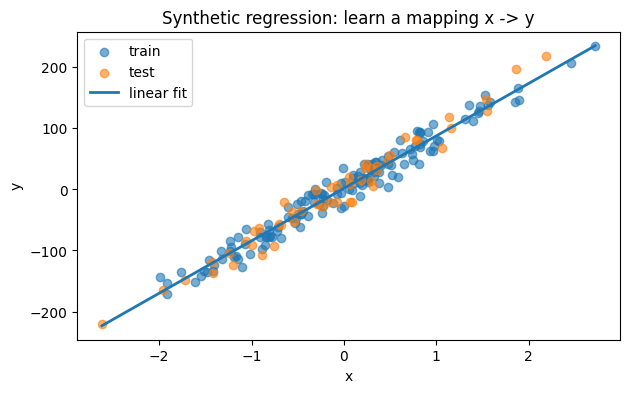

In [4]:
# Synthetic regression (1 feature) to visualize the regression idea
X_syn, y_syn = make_regression(
    n_samples=200, n_features=1, noise=15.0, random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(
    X_syn, y_syn, test_size=0.25, random_state=RANDOM_STATE
)

lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)

print("Synthetic regression RMSE:", rmse(y_test, y_pred))

# Plot
plt.figure(figsize=(7, 4))
plt.scatter(X_train[:, 0], y_train, alpha=0.6, label="train")
plt.scatter(X_test[:, 0], y_test, alpha=0.6, label="test")
xs = np.linspace(X_syn.min(), X_syn.max(), 100).reshape(-1, 1)
plt.plot(xs, lin.predict(xs), linewidth=2, label="linear fit")
plt.title("Synthetic regression: learn a mapping x -> y")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Synthetic classification accuracy: 0.84


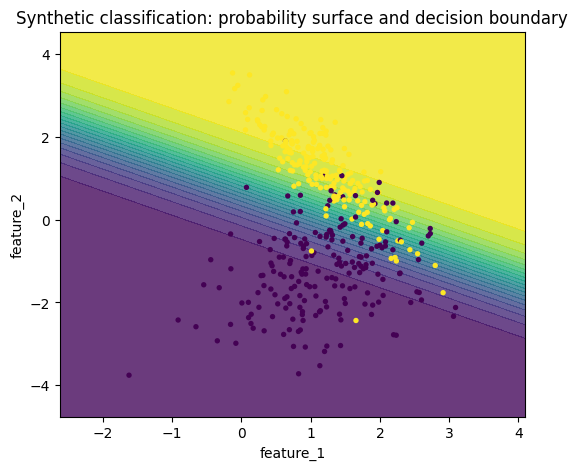

In [5]:
# Synthetic binary classification (2 features) to visualize decision boundaries
X_syn, y_syn = make_classification(
    n_samples=400, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, class_sep=1.2, flip_y=0.03, random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(
    X_syn, y_syn, test_size=0.25, random_state=RANDOM_STATE, stratify=y_syn
)

clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])
clf.fit(X_train, y_train)

print("Synthetic classification accuracy:", accuracy_score(y_test, clf.predict(X_test)))

# Decision boundary plot
x_min, x_max = X_syn[:, 0].min() - 1.0, X_syn[:, 0].max() + 1.0
y_min, y_max = X_syn[:, 1].min() - 1.0, X_syn[:, 1].max() + 1.0
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
zz = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, zz, levels=20, alpha=0.8)
plt.scatter(X_syn[:, 0], X_syn[:, 1], c=y_syn, s=15, edgecolor="none")
plt.title("Synthetic classification: probability surface and decision boundary")
plt.xlabel("feature_1")
plt.ylabel("feature_2")
plt.show()

In [6]:
# Baselines: you should always compute a simple reference performance

def regression_baseline_mean(y_train, y_test):
    y_pred = np.full_like(y_test, fill_value=float(np.mean(y_train)), dtype=float)
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": rmse(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

def classification_baseline_majority(y_train, y_test):
    values, counts = np.unique(y_train, return_counts=True)
    majority = values[np.argmax(counts)]
    y_pred = np.full(len(y_test), majority, dtype=object)
    return {
        "majority_class": majority,
        "accuracy": accuracy_score(y_test, y_pred)
    }

print("Baselines ready.")

Baselines ready.


## ۶. دموی رگرسیون: پیش‌بینی قیمت خانه

اکنون از یک دیتاست واقعیِ موجود در مخزن استفاده می‌کنیم:

- `../../../Datasets/Regression/house-prices.csv`

ستون هدف `Price` است و ویژگی‌هایی مانند متراژ، تعداد اتاق‌ها و ویژگی‌های دسته‌ای مانند `Brick` و `Neighborhood` وجود دارد.

### ۶.۱ ایده‌ی کلیدی: Pipeline جلوی leakage را می‌گیرد

اشتباه رایج این است که پیش‌پردازش را روی کل داده انجام دهید و بعد split کنید؛ این کار اطلاعات test را به train نشت می‌دهد.

برای جلوگیری، از یک **pipeline واحد** شامل مراحل زیر استفاده می‌کنیم:

1. جایگذاری مقادیر گمشده (میانه برای عددی، پرتکرار برای دسته‌ای).
2. مقیاس‌بندی ویژگی‌های عددی.
3. One-Hot برای ویژگی‌های دسته‌ای.
4. مدل رگرسیون (رگرسیون خطی).

سپس `fit()` فقط روی train اجرا می‌شود و تبدیل‌ها از train یاد گرفته می‌شوند.

### ۶.۲ تفسیر نتیجه‌های رگرسیون

در رگرسیون به یک عدد اکتفا نکنید. بررسی کنید:

- MAE/RMSE (خطا در واحد هدف چقدر است؟)
- الگوی residualها (آیا بایاس سیستماتیک داریم؟)
- baseline ساده چقدر خوب است؟

همچنین برای مقایسه‌ی خانواده‌های مدل، یک kNN regressor را هم کنار رگرسیون خطی اجرا می‌کنیم.


In [7]:
# Regression dataset: House prices
house_path = "../../../Datasets/Regression/house-prices.csv"
house = read_csv_or_warn(house_path)

print("Shape:", house.shape)
display(peek(house, 8))

# Target and features
target_col = "Price"
X_house = house.drop(columns=[target_col])
y_house = house[target_col]

print("Target:", target_col)
print("Feature columns:", list(X_house.columns))

Shape: (128, 8)


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East
5,6,114600,1780,3,2,2,No,North
6,7,151600,1830,3,3,3,Yes,West
7,8,150700,2160,4,2,2,No,West


Target: Price
Feature columns: ['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers', 'Brick', 'Neighborhood']


In [8]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_house, y_house, test_size=0.25, random_state=RANDOM_STATE
)

# Identify column types
num_cols = X_house.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_house.columns if c not in num_cols]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# Model
reg_model = LinearRegression()

# Full pipeline
reg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", reg_model)
])

reg_pipe

Numeric columns: ['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers']
Categorical columns: ['Brick', 'Neighborhood']


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Home', 'SqFt', 'Bedrooms',
                                                   'Bathrooms', 'Offers']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brick', 'Neighborhood'])])),
                ('model', LinearRegression())])

In [9]:
# Fit
reg_pipe.fit(X_train, y_train)

# Predict
y_pred = reg_pipe.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse_val = rmse(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse_val:,.2f}")
print(f"R^2  : {r2:,.4f}")

# Baseline comparison
base = regression_baseline_mean(y_train, y_test)
print("\nMean baseline:")
for k, v in base.items():
    print(f"  {k}: {v:,.4f}" if k != "R2" else f"  {k}: {v:.4f}")

MAE  : 8,338.00
RMSE : 10,277.33
R^2  : 0.8277

Mean baseline:
  MAE: 21,206.6406
  RMSE: 25,213.6480
  R2: -0.0370


In [10]:
# Quick model comparison: Linear Regression vs kNN Regression (small tabular demo)
knn_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsRegressor(n_neighbors=7))
])

knn_reg.fit(X_train, y_train)
y_pred_knn = knn_reg.predict(X_test)

print("LinearRegression RMSE:", rmse(y_test, reg_pipe.predict(X_test)))
print("KNNRegressor   RMSE:", rmse(y_test, y_pred_knn))

LinearRegression RMSE: 10277.325457328316
KNNRegressor   RMSE: 12301.983880576303


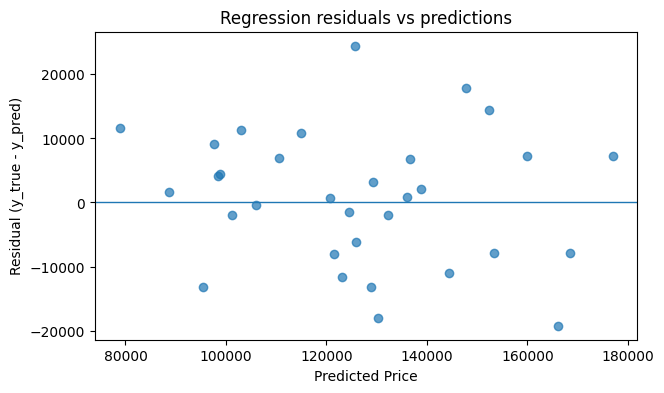

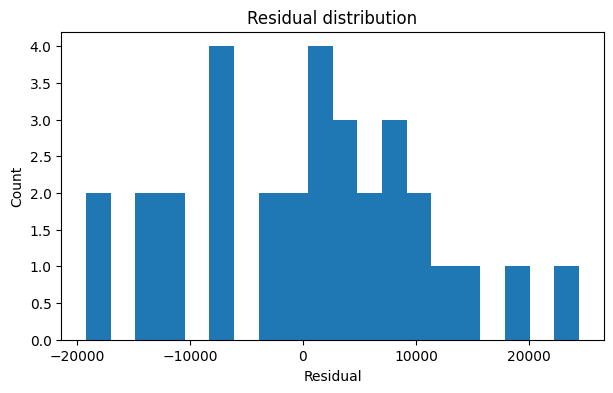

In [11]:
# Residual diagnostics (quick sanity check)
residuals = y_test - y_pred

plt.figure(figsize=(7, 4))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, linewidth=1)
plt.title("Regression residuals vs predictions")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (y_true - y_pred)")
plt.show()

plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=20)
plt.title("Residual distribution")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

In [12]:
# Inspect linear regression coefficients (after preprocessing)
# This is useful to build intuition about how linear models "use" features.

ohe = reg_pipe.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
feature_names_num = num_cols
feature_names_cat = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = feature_names_num + feature_names_cat

coef = reg_pipe.named_steps["model"].coef_
coef_series = pd.Series(coef, index=feature_names).sort_values()

print("Top negative coefficients:")
display(coef_series.head(8))

print("Top positive coefficients:")
display(coef_series.tail(8))

Top negative coefficients:


Offers               -9796.545460
Brick_No             -8311.090234
Neighborhood_East    -7890.376421
Neighborhood_North   -5616.520871
Home                  -316.337403
Bedrooms              2914.090657
Bathrooms             3628.035628
Brick_Yes             8311.090234
dtype: float64

Top positive coefficients:


Neighborhood_East     -7890.376421
Neighborhood_North    -5616.520871
Home                   -316.337403
Bedrooms               2914.090657
Bathrooms              3628.035628
Brick_Yes              8311.090234
SqFt                  12923.472335
Neighborhood_West     13506.897292
dtype: float64

In [13]:
# Make a single prediction (example)
example_row = X_test.iloc[[0]].copy()
print("Example features:")
display(example_row)

pred_price = reg_pipe.predict(example_row)[0]
true_price = y_test.iloc[0]
print(f"Predicted price: {pred_price:,.2f}")
print(f"True price     : {true_price:,.2f}")

Example features:


,Home,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
55,56,1720,2,2,2,Yes,East


Predicted price: 114,866.97
True price     : 125,700.00


## ۷. بیش‌برازش: خطای train در برابر خطای test

مدل‌های منعطف‌تر معمولاً می‌توانند train را بهتر fit کنند، اما خطر این است که به‌جای سیگنال، **نویز** را fit کنند.

یک راه کلاسیک برای دیدن این موضوع، رگرسیون چندجمله‌ای است:

- درجه ۱: خط راست (انعطاف کم)
- درجه‌های بالاتر: منحنی‌های منعطف‌تر

معمولاً می‌بینید:

- خطای train با افزایش درجه کاهش می‌یابد
- خطای test ابتدا کاهش و سپس افزایش می‌یابد (بیش‌برازش)

این پدیده به بده‌بستان bias–variance مرتبط است که در درس‌های بعدی به آن بازمی‌گردیم.


,degree,train_RMSE,test_RMSE
0,1,24.847487,26.700457
1,2,24.781783,26.784210
2,3,24.750996,27.314977
3,5,24.563377,39.224914
4,8,23.876412,262.525439
5,12,23.689409,32291.565974


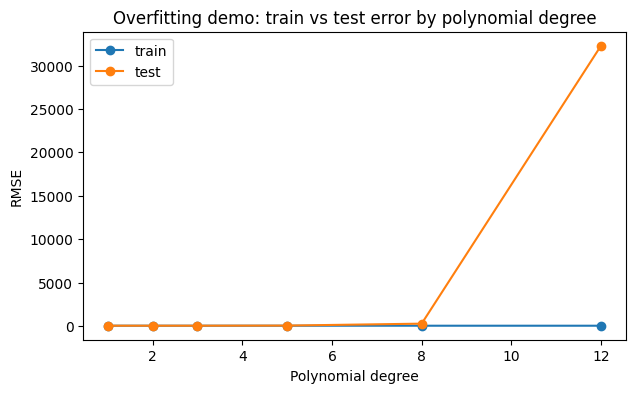

In [14]:
# Overfitting intuition (synthetic): increasing model complexity can hurt test performance

X_syn, y_syn = make_regression(n_samples=250, n_features=1, noise=25.0, random_state=RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(X_syn, y_syn, test_size=0.30, random_state=RANDOM_STATE)

degrees = [1, 2, 3, 5, 8, 12]
results = []

for deg in degrees:
    pipe = Pipeline(steps=[
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("model", LinearRegression())
    ])
    pipe.fit(X_train, y_train)
    train_rmse = rmse(y_train, pipe.predict(X_train))
    test_rmse = rmse(y_test, pipe.predict(X_test))
    results.append((deg, train_rmse, test_rmse))

res_df = pd.DataFrame(results, columns=["degree", "train_RMSE", "test_RMSE"])
display(res_df)

plt.figure(figsize=(7, 4))
plt.plot(res_df["degree"], res_df["train_RMSE"], marker="o", label="train")
plt.plot(res_df["degree"], res_df["test_RMSE"], marker="o", label="test")
plt.title("Overfitting demo: train vs test error by polynomial degree")
plt.xlabel("Polynomial degree")
plt.ylabel("RMSE")
plt.legend()
plt.show()

## ۸. دموی دسته‌بندی: پیش‌بینی وضعیت دیابت

اکنون به دسته‌بندی می‌رویم و از دیتاست زیر استفاده می‌کنیم:

- `../../../Datasets/Classification/diabetes.csv`

ستون هدف `classification` است و دو مقدار `Diabetic` و `Non-Diabetic` دارد.

### ۸.۱ رگرسیون لجستیک به‌عنوان baseline

رگرسیون لجستیک برای بسیاری از مسائل جدولی baseline خوبی است:

- سریع
- خروجی احتمالاتی (`predict_proba`)
- نسبتاً قابل تفسیر (ضرایب) با استانداردسازی ویژگی‌ها

گام‌ها:

1. split با `stratify=y`
2. pipeline شامل imputation + scaling
3. آموزش لجستیک
4. ارزیابی با accuracy/precision/recall/F1 و ROC/AUC
5. تنظیم آستانه (threshold tuning)
6. مقایسه‌ی کوتاه با kNN

### ۸.۲ آستانه بخشی از تصمیم است

حتی اگر احتمال‌ها ثابت باشند، تغییر آستانه confusion matrix را تغییر می‌دهد.

این همان ابزاری است که با آن مدل را با هزینه‌ها سازگار می‌کنید:

- recall بالا (گرفتن بیشتر مثبت‌ها، با افزایش FP)
- precision بالا (کاهش FP، با افزایش FN)

آستانه‌ی پیش‌فرض را بدون تحلیل هزینه‌ها «درست» فرض نکنید.


In [15]:
# Classification dataset: Diabetes
diab_path = "../../../Datasets/Classification/diabetes.csv"
diab = read_csv_or_warn(diab_path)

print("Shape:", diab.shape)
display(peek(diab, 8))

target_col = "classification"
X_diab = diab.drop(columns=[target_col])
y_diab = diab[target_col]

print("Target:", target_col)
print("Class distribution:")
display(y_diab.value_counts(dropna=False))

Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic
5,5,116,74,0,0,25.6,0.201,30,Non-Diabetic
6,3,78,50,32,88,31.0,0.248,26,Diabetic
7,10,115,0,0,0,35.3,0.134,29,Non-Diabetic


Target: classification
Class distribution:


classification
Non-Diabetic    500
Diabetic        268
Name: count, dtype: int64

In [16]:
# Split (stratify keeps class balance stable across train/test)
X_train, X_test, y_train, y_test = train_test_split(
    X_diab, y_diab, test_size=0.25, random_state=RANDOM_STATE, stratify=y_diab
)

# All features are numeric in this dataset
num_cols = X_diab.columns.tolist()

clf_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

clf_model = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)

clf_pipe = Pipeline(steps=[
    ("preprocess", clf_preprocess),
    ("model", clf_model)
])

clf_pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('model', LogisticRegression(max_iter=2000, random_state=42))])

In [17]:
# Fit
clf_pipe.fit(X_train, y_train)

# Predictions
y_pred = clf_pipe.predict(X_test)

# Basic metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label="Diabetic")
rec = recall_score(y_test, y_pred, pos_label="Diabetic")
f1 = f1_score(y_test, y_pred, pos_label="Diabetic")

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}  (positive class = 'Diabetic')")
print(f"Recall   : {rec:.4f}")
print(f"F1       : {f1:.4f}")

# Baseline accuracy
base = classification_baseline_majority(y_train, y_test)
print("\nMajority baseline:")
print("  majority_class:", base["majority_class"])
print("  accuracy      :", base["accuracy"])

print("\nClassification report:")
print(classification_report(y_test, y_pred))

Accuracy : 0.7865
Precision: 0.7407  (positive class = 'Diabetic')
Recall   : 0.5970
F1       : 0.6612

Majority baseline:
  majority_class: Non-Diabetic
  accuracy      : 0.6510416666666666

Classification report:
              precision    recall  f1-score   support

    Diabetic       0.74      0.60      0.66        67
Non-Diabetic       0.80      0.89      0.84       125

    accuracy                           0.79       192
   macro avg       0.77      0.74      0.75       192
weighted avg       0.78      0.79      0.78       192



In [18]:
# Confusion matrix
labels = ["Non-Diabetic", "Diabetic"]
cm = confusion_matrix(y_test, y_pred, labels=labels)

cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in labels], columns=[f"pred_{l}" for l in labels])
display(cm_df)

,pred_Non-Diabetic,pred_Diabetic
true_Non-Diabetic,111,14
true_Diabetic,27,40


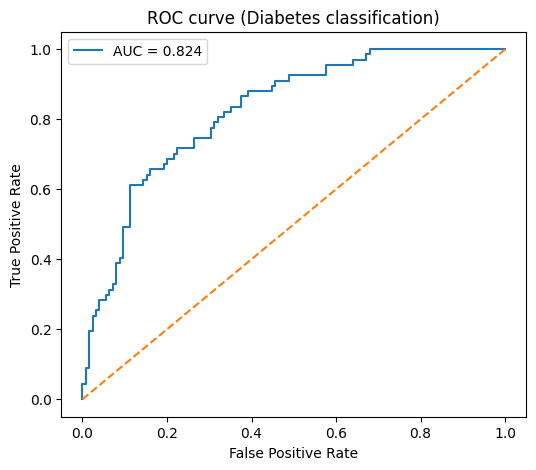

AUC: 0.8236417910447761


In [19]:
# ROC curve (requires probabilities for the positive class)
proba = clf_pipe.predict_proba(X_test)

# Map class ordering to find probability column for 'Diabetic'
class_order = clf_pipe.named_steps["model"].classes_
pos_idx = int(np.where(class_order == "Diabetic")[0][0])

y_score = proba[:, pos_idx]

# Convert y_test to binary for ROC computation
y_true_bin = (y_test.values == "Diabetic").astype(int)

fpr, tpr, thresholds = roc_curve(y_true_bin, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC curve (Diabetes classification)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print("AUC:", roc_auc)

In [20]:
# Threshold tuning example: choose a threshold to trade precision vs recall
threshold = 0.40  # try 0.30, 0.50, 0.60 and compare

y_pred_thr = np.where(y_score >= threshold, "Diabetic", "Non-Diabetic")

acc_thr = accuracy_score(y_test, y_pred_thr)
prec_thr = precision_score(y_test, y_pred_thr, pos_label="Diabetic")
rec_thr = recall_score(y_test, y_pred_thr, pos_label="Diabetic")
f1_thr = f1_score(y_test, y_pred_thr, pos_label="Diabetic")

print(f"Threshold: {threshold:.2f}")
print(f"Accuracy : {acc_thr:.4f}")
print(f"Precision: {prec_thr:.4f}")
print(f"Recall   : {rec_thr:.4f}")
print(f"F1       : {f1_thr:.4f}")

Threshold: 0.40
Accuracy : 0.7708
Precision: 0.6769
Recall   : 0.6567
F1       : 0.6667


In [21]:
# Inspect logistic regression coefficients (feature importance in a linear sense)
coef = clf_pipe.named_steps["model"].coef_.ravel()
coef_s = pd.Series(coef, index=num_cols).sort_values()

print("Most negative coefficients (push toward Non-Diabetic):")
display(coef_s.head(6))

print("Most positive coefficients (push toward Diabetic):")
display(coef_s.tail(6))

Most negative coefficients (push toward Non-Diabetic):


Glucose                    -1.123980
BMI                        -0.671558
Pregnancies                -0.466742
DiabetesPedigreeFunction   -0.280567
Age                        -0.161259
SkinThickness              -0.108893
dtype: float64

Most positive coefficients (push toward Diabetic):


Pregnancies                -0.466742
DiabetesPedigreeFunction   -0.280567
Age                        -0.161259
SkinThickness              -0.108893
Insulin                     0.177319
BloodPressure               0.312878
dtype: float64

In [22]:
# Quick model comparison: Logistic Regression vs kNN Classifier

knn_clf = Pipeline(steps=[
    ("preprocess", clf_preprocess),
    ("model", KNeighborsClassifier(n_neighbors=9))
])

knn_clf.fit(X_train, y_train)

acc_log = accuracy_score(y_test, clf_pipe.predict(X_test))
acc_knn = accuracy_score(y_test, knn_clf.predict(X_test))

print("LogisticRegression accuracy:", acc_log)
print("KNNClassifier     accuracy:", acc_knn)

LogisticRegression accuracy: 0.7864583333333334
KNNClassifier     accuracy: 0.734375


## ۹. (اختیاری) دموی چندکلاسه: Iris

دسته‌بندی فقط دودویی نیست؛ مسائل چندکلاسه با $K > 2$ نیز بسیار رایج‌اند.

از دیتاست زیر استفاده می‌کنیم:

- `../../../Datasets/Classification/iris.csv`

این بخش دوباره تأکید می‌کند که یادگیری نظارت‌شده عمدتاً یک **workflow** است:

- تعریف $X$ و $y$
- split
- پیش‌پردازش
- fit
- ارزیابی


In [23]:
# Optional: Multi-class classification with Iris (demonstrates the same supervised pattern)
iris_path = "../../../Datasets/Classification/iris.csv"
iris = read_csv_or_warn(iris_path)

print("Shape:", iris.shape)
display(peek(iris, 8))

target_col = "classification"
X_iris = iris.drop(columns=[target_col])
y_iris = iris[target_col]

print("Class distribution:")
display(y_iris.value_counts())

Shape: (150, 5)


,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.4,3.7,1.5,0.2,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
2,4.8,3.0,1.4,0.1,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa
5,5.7,4.4,1.5,0.4,Iris-setosa
6,5.4,3.9,1.3,0.4,Iris-setosa
7,5.1,3.5,1.4,0.3,Iris-setosa


Class distribution:


classification
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X_iris, y_iris, test_size=0.25, random_state=RANDOM_STATE, stratify=y_iris
)

iris_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000))
])

iris_pipe.fit(X_train, y_train)
y_pred = iris_pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9210526315789473
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       0.86      0.92      0.89        13
 Iris-virginica       0.92      0.85      0.88        13

       accuracy                           0.92        38
      macro avg       0.92      0.92      0.92        38
   weighted avg       0.92      0.92      0.92        38



## ۱۰. ذهنیت عملی: صورت‌بندی، baseline، و حالت‌های شکست

### ۱۰.۱ چک‌لیست صورت‌بندی

قبل از نوشتن کد، به این سؤال‌ها جواب دهید:

1. $y$ دقیقاً چیست؟ چگونه اندازه‌گیری شده؟ ممکن است نویز یا خطا داشته باشد؟
2. هنگام پیش‌بینی $y$، چه اطلاعاتی واقعاً در زمان پیش‌بینی در دسترس است؟
3. کدام هزینه‌ها مهم‌اند: FP، FN، خطاهای بزرگ در رگرسیون، یا محدودیت زمان اجرا؟
4. baseline معنی‌دار چیست؟

### ۱۰.۲ baselineها (همیشه بسازید)

- baseline رگرسیون: پیش‌بینی میانگین (یا میانه) اهداف train.
- baseline دسته‌بندی: پیش‌بینی پرتکرارترین کلاس.

اگر مدل شما فقط کمی بهتر از baseline است، احتمالاً به ویژگی‌های بهتر، داده‌ی بهتر، یا حتی تعریف بهتر مسئله نیاز دارید.

### ۱۰.۳ خطاهای رایج

- leakage
- fit کردن پیش‌پردازش روی کل داده
- split اشتباه
- انتخاب معیار نامناسب
- نادیده‌گرفتن عدم‌قطعیت
- تغییر توزیع داده (dataset shift)

### ۱۰.۴ یادداشت کوتاه درباره‌ی dataset shift

حتی اگر ارزیابی امروز عالی باشد، اگر توزیع داده تغییر کند عملکرد افت می‌کند. مثال‌ها:

- تغییر بازار و محله‌های جدید
- تغییر نحوه‌ی اندازه‌گیری در داده‌های پزشکی
- تغییر رفتار کاربران پس از به‌روزرسانی محصول

راهکارها شامل پایش، بازآموزی دوره‌ای، و اعتبارسنجی مقاوم‌تر است (در فصل‌های MLOps دوباره می‌آید).


## ۱۱. تمرین‌ها (پیشنهادی)

### تمرین A — رگرسیون

1. `LinearRegression()` را با `Ridge(alpha=...)` جایگزین کنید و MAE/RMSE را مقایسه کنید.  
2. scaling را حذف کنید و دوباره اجرا کنید. آیا نتیجه برای رگرسیون خطی تغییر می‌کند؟ چرا scaling برای kNN مهم‌تر است؟
3. baseline میانگین (نمایش داده شده) را با baseline میانه مقایسه کنید.
4. در بخش بیش‌برازش، درجه‌های بیشتری اضافه کنید و ببینید منحنی U شکل واضح‌تر می‌شود یا نه.

### تمرین B — دسته‌بندی

1. آستانه را از `0.40` به `0.30` و `0.60` تغییر دهید و precision/recall را مقایسه کنید.
2. برای هر آستانه confusion matrix را نمایش دهید.
3. تعداد همسایه‌های kNN را تغییر دهید و ببینید accuracy چطور تغییر می‌کند.
4. ویژگی‌هایی با ضرایب مثبت/منفی بزرگ در لجستیک را پیدا کنید و بررسی کنید آیا با انتظار دامنه‌ای سازگار است یا نه.

### تمرین C — گزارش‌نویسی

یک خلاصه‌ی «شبیه model card» بنویسید:

- هدف چیست؟ ویژگی‌ها چیستند؟
- چه معیارهایی گزارش شده و چرا؟
- محدودیت‌ها و ریسک‌ها چیستند (leakage، shift، عدم‌توازن، نمونه‌ی کم، ...)?


## ۱۲. جمع‌بندی

در این درس، تفکیک پایه‌ای یادگیری نظارت‌شده را یاد گرفتید:

- **رگرسیون** اهداف پیوسته را پیش‌بینی می‌کند و غالباً با lossهایی مانند خطای مربعی آموزش داده می‌شود.
- **دسته‌بندی** برچسب‌های گسسته را پیش‌بینی می‌کند و غالباً با آنتروپی متقاطع / log loss آموزش داده می‌شود.

همچنین چند pipeline کامل را با دیتاست‌های واقعیِ همین مخزن پیاده‌سازی کردید:

- رگرسیون قیمت خانه (MAE/RMSE/$R^2$ + baseline + residual + ضرایب)
- دسته‌بندی دیابت (accuracy/precision/recall/F1 + baseline + ROC/AUC + آستانه + ضرایب)

در نهایت، با مشاهده‌ی افزایش خطای test در مدل‌های بسیار پیچیده، شهود اولیه درباره‌ی **بیش‌برازش** ساختید.

در درس‌های بعدی فصل ۴، وارد جزئیات رگرسیون خطی، لجستیک، regularization و معیارهای ارزیابی می‌شوید.
